In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import pickle
import itertools
import time
import ot
import os
from scipy.stats import rankdata, kendalltau, spearmanr
import seaborn as sns
from datetime import datetime
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter1d

In [2]:
alpha_arr = np.linspace(-0.5, 0.5, 51)*10.0

In [3]:
bench_zero = True

In [4]:
log_dir = './CobbDouglas_logs'
cali_dir = './CobbDouglas_cali'

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')

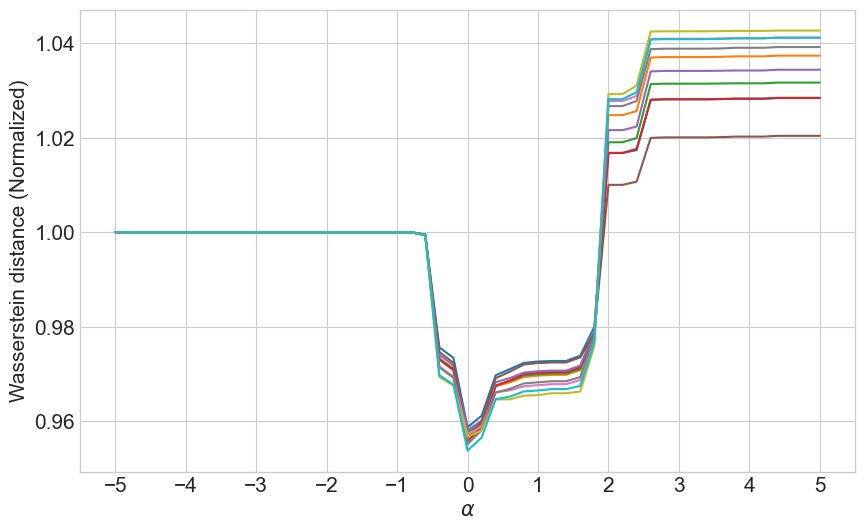

In [6]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
plt.figure(figsize=(10, 6))

for k in range(10):   
    sub_folder = "sim_{}_zero_{}".format(k, bench_zero)
    sub_dir = "{}/{}".format(cali_dir, sub_folder)

    with open('{}/sink_arr.pickle'.format(sub_dir), 'rb') as fp:
        sink = pickle.load(fp)
    plt.plot(alpha_arr, sink/sink[0])
    plt.xticks(np.arange(11) - 5)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel(r'$\alpha$', fontsize=15)
    plt.ylabel('Wasserstein distance (Normalized)', fontsize=15)   
plt.savefig('matched_corr.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [7]:
for k in range(10):
    sub_folder = "sim_{}_zero_{}".format(k, bench_zero)
    sub_dir = "{}/{}".format(cali_dir, sub_folder)

    with open('{}/sink_arr.pickle'.format(sub_dir), 'rb') as fp:
        sink = pickle.load(fp)

    cand = np.where(sink == sink.min())[0]
    min_id = cand[np.argmin(np.abs(cand-25))]
    print(min_id, alpha_arr[min_id])

25 0.0
25 0.0
25 0.0
25 0.0
25 0.0
25 0.0
25 0.0
25 0.0
25 0.0
25 0.0


In [8]:
dir_wage = './CobbDouglas_logs/zero_True/sim_9_alpha_25'

with open('{}/wage_init.pickle'.format(dir_wage), 'rb') as fp:
    wage_init = pickle.load(fp)
    
with open('{}/ot_init.pickle'.format(dir_wage), 'rb') as fp:
    ot_init = pickle.load(fp)

In [9]:
np.round(wage_init - np.min(wage_init), 3)

array([0.697, 0.398, 0.236, 0.095, 0.   ])

In [10]:
# number of paired firm-worker with nonzero prob
num_cell = np.where(ot_init > 0)[0].shape[0]
firm_idx = np.zeros(num_cell)
worker_rank = np.zeros(num_cell)
worker_salary = np.zeros(num_cell)
pair_prob =  np.zeros(num_cell)

In [11]:
# inital wage
tmp_id = 0
for f_idx in range(5):
    for w_idx in range(5):
        if ot_init[f_idx, w_idx] > 0:
            firm_idx[tmp_id] = f_idx
            worker_rank[tmp_id] = w_idx
            worker_salary[tmp_id] = wage_init[w_idx] - np.min(wage_init)
            pair_prob[tmp_id] = ot_init[f_idx, w_idx]
            tmp_id += 1
            print(f_idx, w_idx, wage_init[w_idx], ot_init[f_idx, w_idx])
            # print(wage_init - np.min(wage_init))

0 0 1.0897988602581599 0.125
1 0 1.0897988602581599 0.07500000000000001
1 1 0.7905232083124929 0.175
2 1 0.7905232083124929 0.025000000000000022
2 2 0.6290168547163013 0.2
2 3 0.48811183257432944 0.024999999999999967
3 3 0.48811183257432944 0.17500000000000004
3 4 0.39261274523497924 0.07499999999999996
4 4 0.39261274523497924 0.125


In [12]:
# average salary
(pair_prob*worker_salary).sum()

0.2853999549842733

In [13]:
ot_init

array([[0.125, 0.   , 0.   , 0.   , 0.   ],
       [0.075, 0.175, 0.   , 0.   , 0.   ],
       [0.   , 0.025, 0.2  , 0.025, 0.   ],
       [0.   , 0.   , 0.   , 0.175, 0.075],
       [0.   , 0.   , 0.   , 0.   , 0.125]])

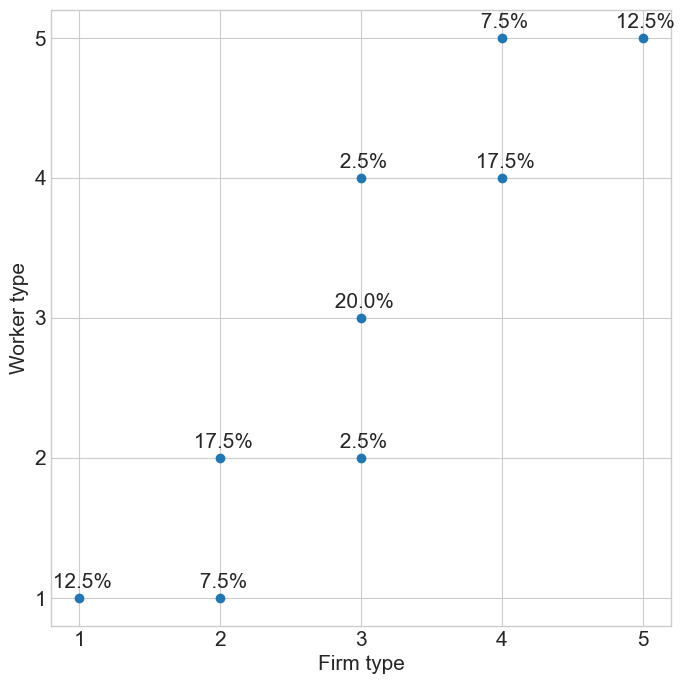

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(firm_idx+1, worker_rank+1, '.', markersize=12)
plt.xticks(np.arange(5)+1)
plt.yticks(np.arange(5)+1)
tmp_ = 0
for x, y in zip(firm_idx+1, worker_rank+1):
    plt.text(x, y+0.04, ' {:.1f}%'.format(pair_prob[tmp_]*100), fontsize=15, horizontalalignment='center', verticalalignment='bottom')
    tmp_ += 1
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Firm type', fontsize=15)
plt.ylabel('Worker type', fontsize=15)   
plt.savefig('matched_firm_worker.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

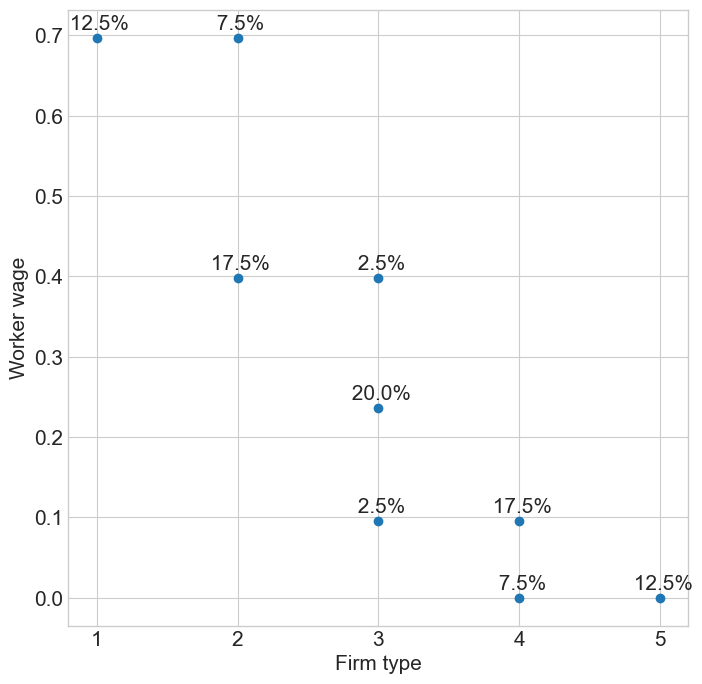

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(firm_idx+1, worker_salary, '.', markersize=12)
plt.xticks(np.arange(5)+1)
# plt.yticks(np.arange(5)+1)
tmp_ = 0
for x, y in zip(firm_idx+1, worker_salary):
    plt.text(x, y+0.005, ' {:.1f}%'.format(pair_prob[tmp_]*100), fontsize=15, horizontalalignment='center', verticalalignment='bottom')
    tmp_ += 1
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Firm type', fontsize=15)
plt.ylabel('Worker wage', fontsize=15)   
plt.savefig('matched_firm_salary.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

## Some statistical fact of data

In [16]:
with open('{}/value_func.pickle'.format(dir_wage), 'rb') as fp:
    value_func = pickle.load(fp)

In [17]:
cost_mat = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        cost_mat[i, j] = -1/(i+1)*(5**0.6 - (j+1)**0.6)

In [20]:
cost_mat

array([[-1.6265278 , -1.11081124, -0.69334576, -0.32913109, -0.        ],
       [-0.8132639 , -0.55540562, -0.34667288, -0.16456555, -0.        ],
       [-0.54217593, -0.37027041, -0.23111525, -0.10971036, -0.        ],
       [-0.40663195, -0.27770281, -0.17333644, -0.08228277, -0.        ],
       [-0.32530556, -0.22216225, -0.13866915, -0.06582622, -0.        ]])

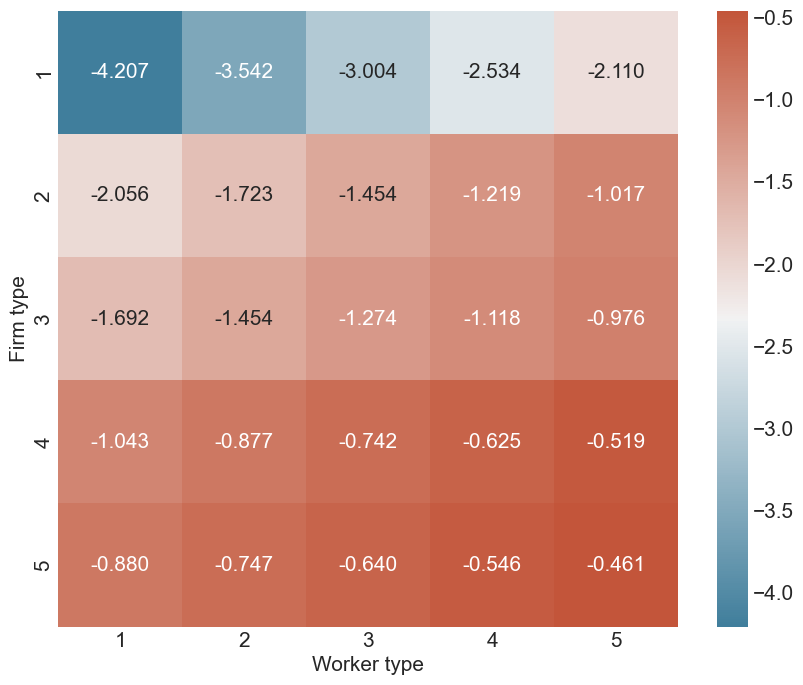

In [18]:
x_shape = 5
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cost_mat+value_func[0, :, :], xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".3f", annot_kws={"fontsize": 15}, cmap=cmap)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Worker type', fontsize=15)
plt.ylabel('Firm type', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.savefig('matched_cost.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [19]:
surplus = - cost_mat - value_func[0, :, :]
for i in range(5):
    for i_p in range(i, 5):
        for j in range(5):
            for j_p in range(j, 5):
                if surplus[i, j] + surplus[i_p, j_p] < surplus[i, j_p] + surplus[i_p, j]:
                    print('supermodular property failed')